In [1]:
from aquabyte.data_access_utils import RDSAccessUtils, S3AccessUtils
import json
import os
import  pandas as pd
from aquabyte.visualize import Visualizer
import matplotlib.patches as patches
from tqdm import tqdm

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
%matplotlib inline
from utils import utils, data_prep


In [2]:

from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed

In [26]:
import importlib
importlib.reload(utils)
importlib.reload(data_prep)

<module 'utils.data_prep' from '/root/jane/cv_research/jane/lice_counting/utils/data_prep.py'>

In [4]:
SEED = 33
CROP_WIDTH = 512
CROP_HEIGHT = 512


LABEL_PATH = 'data/lice_crop_labels'
IMAGE_PATH = 'data/lice_crop_images'

In [5]:
# docker-compose up 
# credentials = json.load(open(os.environ["DATA_WAREHOUSE_SQL_CREDENTIALS"]))

# docker run
credentials = json.load(open("/root/jane/cv_research/jane/deploy/data_warehouse_sql_credentials.json"))

rds_access_utils = RDSAccessUtils(credentials)

get_annotation_data = """
    SELECT 
        * 
    FROM 
        prod.crop_annotation 
    WHERE 
        (captured_at BETWEEN '2019-10-01' AND '2019-12-01') AND 
        (group_id = '56') AND
        (annotation_state_id IN (7)) AND
        (service_id = 1);
"""
annotation_data = rds_access_utils.extract_from_database(get_annotation_data)

In [6]:
annotation_data.head(3)

service_id  pen_id  annotation_state_id  \
0           1      56                    7   
1           1      56                    7   
2           1      56                    7   

                                                                                                                                                   base_key  \
0  https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:13:42.783757000Z/   
1  https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/   
2  https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:15:12.635108000Z/   

                                                                                                                                                                                          url_key  \
0   https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:13:42.783757000Z/left_frame_crop_846_600_3122_1385.jpg   
1  https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/left_frame_crop_1286_524_3434_1555.jpg   
2   https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:15:12.635108000Z/left_frame_crop_958_178_3274_1374.jpg   

  right_crop_url  \
0           None   
1           None   
2           None   

                                                                                                                                                                                                                                                                         left_crop_metadata  \
0   {'width': 2307, 'height': 800, 'x_coord': 828, 'y_coord': 576, 'depth_mm': 484.16502232176987, 'crop_area': 1786660, 'quality_score': 0.9870305694416996, 'mean_luminance': 13.418134396023866, 'edge_detection_score': 0.16698476486852562, 'mean_green_luminance': 29.66566446109884}   
1  {'width': 2178, 'height': 1050, 'x_coord': 1274, 'y_coord': 498, 'depth_mm': 488.9474956776813, 'crop_area': 2214588, 'quality_score': 0.9831454731159667, 'mean_luminance': 20.04596520887858, 'edge_detection_score': 0.18689209911730761, 'mean_green_luminance': 36.247277113011066}   
2   {'width': 2348, 'height': 1216, 'x_coord': 941, 'y_coord': 149, 'depth_mm': 447.1005560185746, 'crop_area': 2769936, 'quality_score': 0.9999065913844286, 'mean_luminance': 17.375244770998318, 'edge_detection_score': 0.12959180284309815, 'mean_green_luminance': 38.21422710233998}   

  right_crop_metadata  \
0                None   
1                None   
2                None   

                                                                                                                                                                                                                                                                                                                                                                                          camera_metadata  \
0  {'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}   
1  {'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-ster

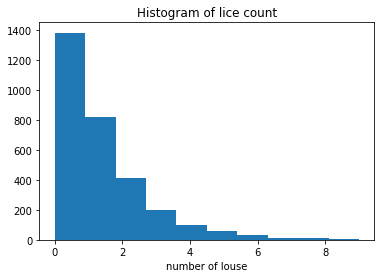

In [7]:


lice_count = []
for _, sf in annotation_data.iterrows():
    if sf['annotation']:
        lice_count.append(len(sf['annotation']))
    else:
        lice_count.append(0)
        
_ = plt.hist(lice_count)  # arguments are passed to np.histogram
#_ = plt.hist(orientation, bins=20)
plt.title("Histogram of lice count")
plt.xlabel('number of louse')
plt.show()

# fish crop with lice bbox

In [9]:
# s3_access_utils = S3AccessUtils('/root/data')

import boto3
from urllib.parse import urlparse


aws_credentials = json.load(open('/root/jane/cv_research/jane/deploy/aws_credentials.json'))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
aws_secret_access_key=aws_credentials["aws_secret_access_key"],
            region_name="eu-west-1")

def recursive_mkdir(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    return
    
def download_from_s3(bucket, key, custom_location=None):
    if custom_location:
        recursive_mkdir(os.path.dirname(custom_location))
        s3_client.download_file(bucket, key, custom_location)
    else:
        s3_base_dir = os.path.join('/root/data', 's3')
        f = os.path.join(s3_base_dir, bucket, key)
        if not os.path.exists(f):
            recursive_mkdir(os.path.dirname(f))
            s3_client.download_file(bucket, key, f)
        return f
    
def download_from_url(url):
    parsed_url = urlparse(url, allow_fragments=False)
    if parsed_url.netloc.startswith('s3'):
        url_components = parsed_url.path.lstrip('/').split('/')
        bucket, key = url_components[0], os.path.join(*url_components[1:])
    else:
        bucket = parsed_url.netloc.split('.')[0]
        key = parsed_url.path.lstrip('/')
    image_f = download_from_s3(bucket, key)
    return image_f, bucket, key

10it [00:00, 11.42it/s]


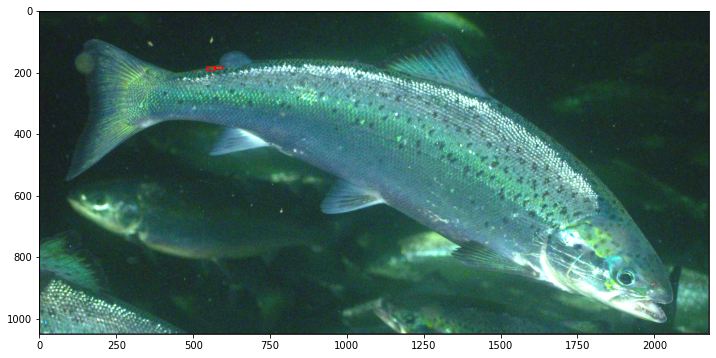

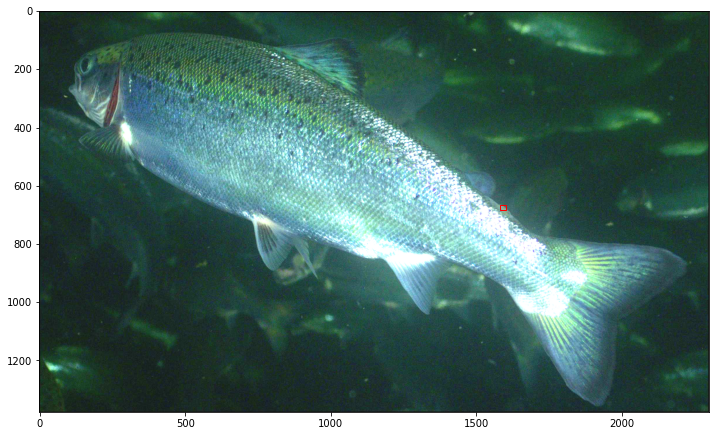

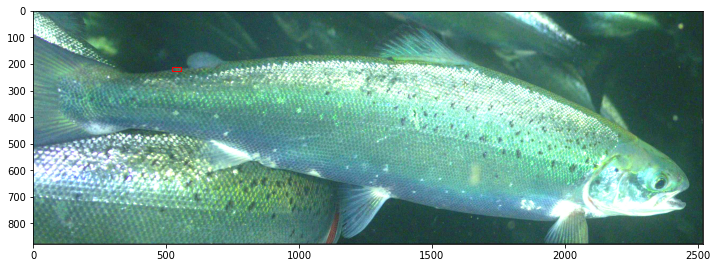

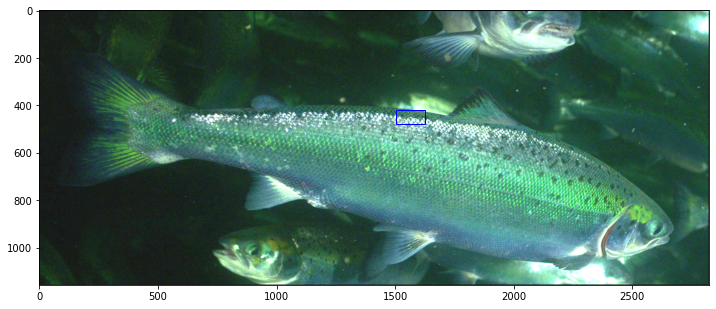

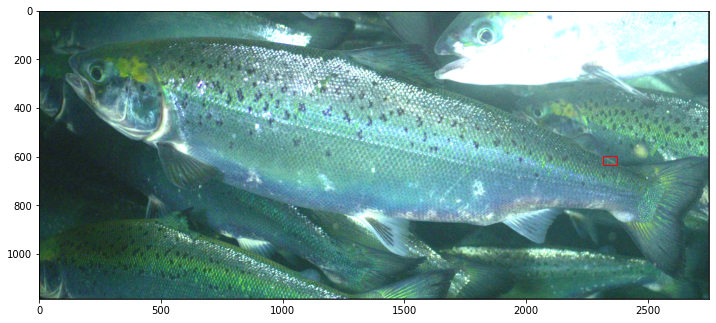

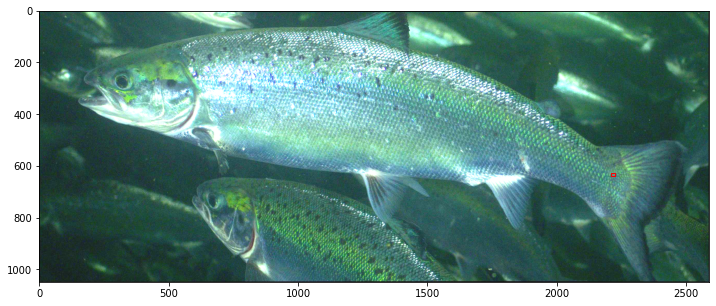

In [12]:
import cv2

for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation']:
        continue
    if idx > 10:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    fig, ax = plt.subplots(figsize=(12, 12)) 
    image = plt.imread(image_f)


    alpha = 3 # Contrast control (1.0-3.0)
    beta = 20 # Brightness control (0-100)

    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)



    ax.imshow(adjusted)
    
    for lice in sf['annotation']:
        lp = lice['position'] # only take the first female adult
        x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
        if lice['category'] == 'ADULT_FEMALE':
            ec = 'b'
        else:
            ec = 'r'
        rect = patches.Rectangle((x, y), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
        ax.add_patch(rect)
plt.show()

# lice crop

1it [00:00,  4.67it/s]

[{'id': 'd54c4dd0-e413-11e9-a674-ad85428a0e40', 'category': 'ADULT_FEMALE', 'location': 'TOP', 'position': {'top': 366, 'left': 1063, 'width': 54, 'height': 28}}]
num of crops 1
crop 771 281


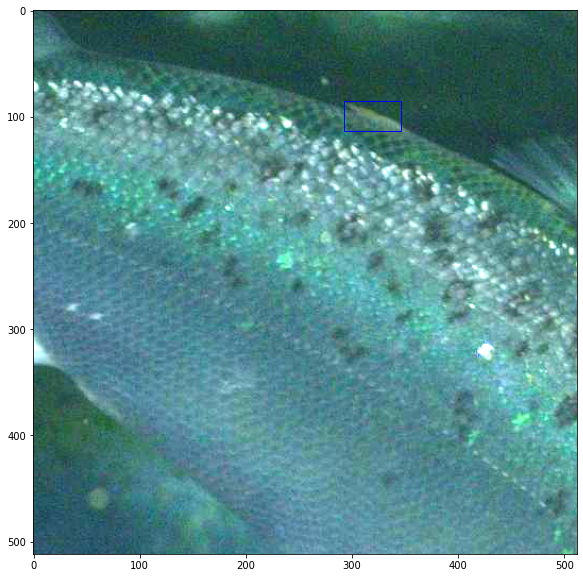

12it [00:00,  6.25it/s]

[{'id': 1, 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 971, 'left': 1582, 'width': 51, 'height': 51}}, {'id': 'c32fce40-e41f-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 788, 'left': 1421, 'width': 17, 'height': 20}}]
num of crops 2
crop 1259 852


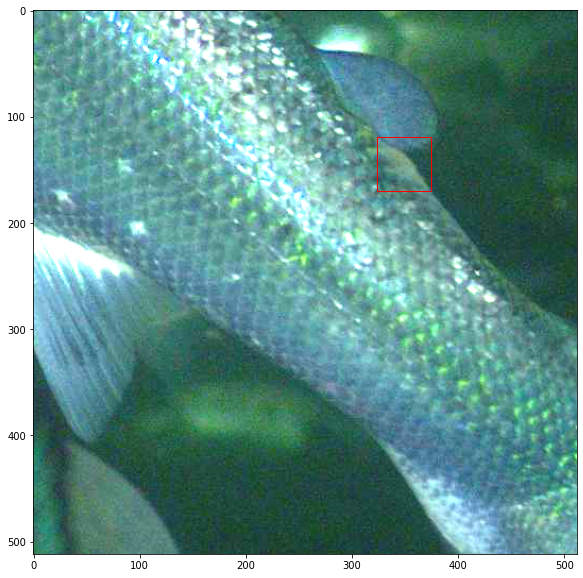

crop 1003 358


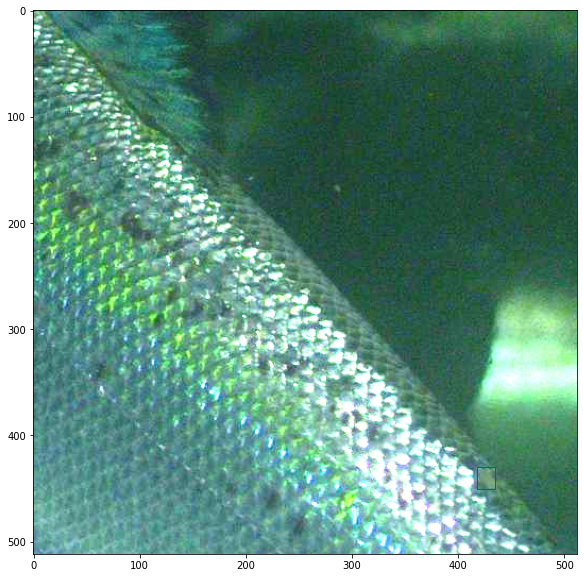

14it [00:01,  4.41it/s]

[{'id': 1, 'category': 'ADULT_FEMALE', 'location': 'MIDDLE', 'position': {'top': 203, 'left': 1261, 'width': 66, 'height': 33}}, {'id': 2, 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 213, 'left': 2006, 'width': 25, 'height': 9}}, {'id': 3, 'category': 'MOVING', 'location': 'MIDDLE', 'position': {'top': 574, 'left': 351, 'width': 25, 'height': 24}}]
num of crops 3
crop 1120 81


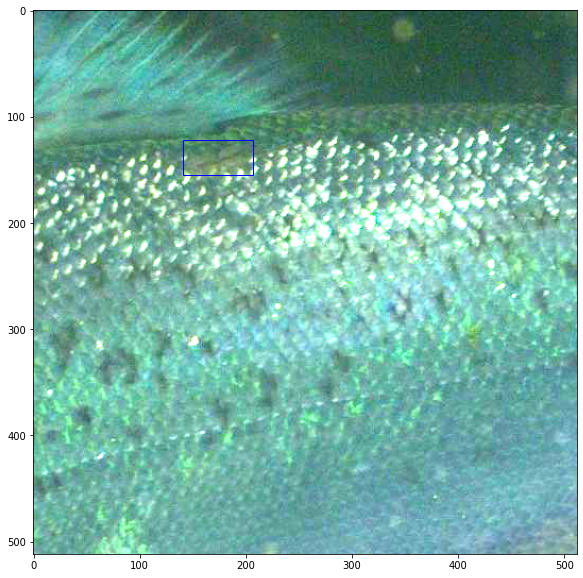

crop 1673 77


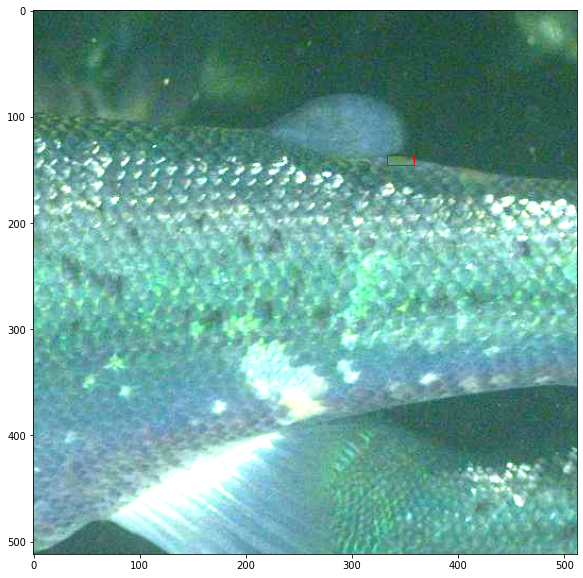

crop 81 473


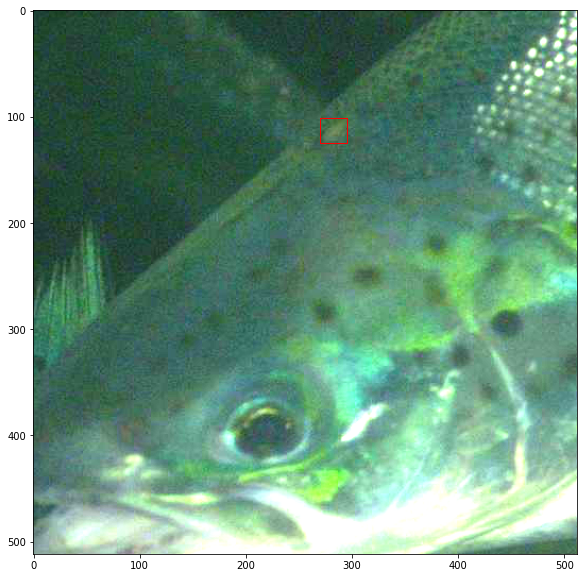

15it [00:02,  1.99it/s]

[{'id': 1, 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 443, 'left': 475, 'width': 48, 'height': 39}}, {'id': '4e560f22-e420-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 450, 'left': 484, 'width': 15, 'height': 15}}, {'id': '4e560f23-e420-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 458, 'left': 498, 'width': 14, 'height': 14}}]
num of crops 1
crop 142 128


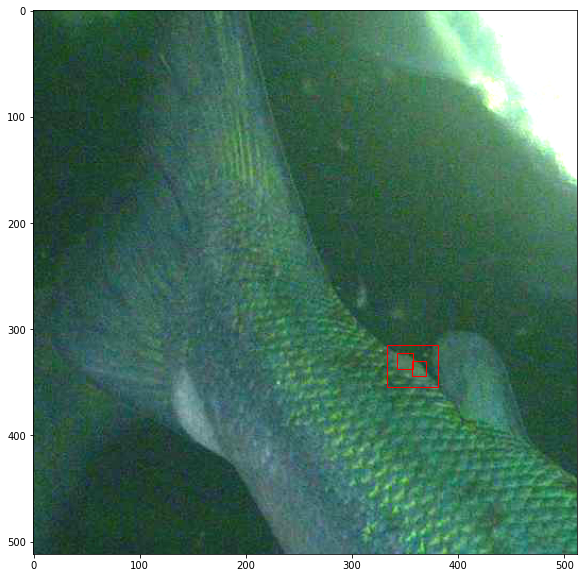

18it [00:02,  2.57it/s]

[{'id': 'd54c4dd1-e413-11e9-a674-ad85428a0e40', 'category': 'ADULT_FEMALE', 'location': 'TOP', 'position': {'top': 315, 'left': 1263, 'width': 60, 'height': 15}}, {'id': 'd54c4dd2-e413-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'MIDDLE', 'position': {'top': 331, 'left': 1287, 'width': 11, 'height': 8}}]
num of crops 1
crop 1006 151


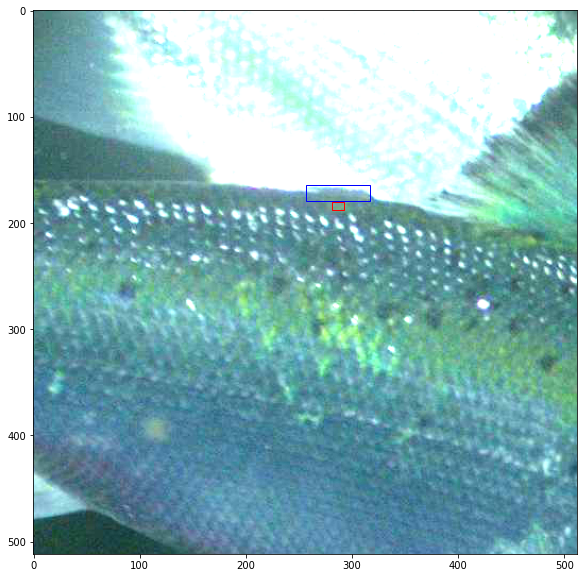

19it [00:03,  5.90it/s]


In [19]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation'] or idx < 10:
        continue
    if idx > 20:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    print(sf['annotation'])
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT])

    print("num of crops {}".format(len(crops)))
    for crop in crops:
        
        fig, ax = plt.subplots(figsize=(10, 10))
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        print("crop {} {}".format(crop_left, crop_top))
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        # adjust image contrast and brightness
        alpha = 3 # Contrast control (1.0-3.0)
        beta = 20 # Brightness control (0-100)
        adjusted = cv2.convertScaleAbs(cropped_image, alpha=alpha, beta=beta)
        
        ax.imshow(adjusted)

    
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            if lice['category'] == 'ADULT_FEMALE':
                ec = 'b'
            else:
                ec = 'r'
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top
            rect = patches.Rectangle((crop_left_offset, crop_top_offset), w, h,linewidth=1,edgecolor=ec,facecolor='none')    
            ax.add_patch(rect)    

        plt.show()

In [33]:
seed(SEED)
for idx, sf in tqdm(annotation_data.iterrows()):
    if not sf['annotation'] or idx < 10:
        continue
    if idx > 20:
        break
    left_image_f, bucket, left_image_key = download_from_url(sf["left_crop_url"])
    image_f = left_image_f 

    iw = sf['left_crop_metadata']['width']
    ih = sf['left_crop_metadata']['height']
    print(sf['annotation'])
    crops = data_prep.generate_crops(sf['annotation'], [iw, ih], [CROP_WIDTH, CROP_HEIGHT])

    print("num of crops {}".format(len(crops)))
    i = 0
    for crop in crops:
        i += 1
        image = plt.imread(image_f)
        
        # crop lice image
        crop_left, crop_top = crop
        print("crop {} {}".format(crop_left, crop_top))
        cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
        
        start, end = "left_frame_crop_", ".jpg"
        s = sf["left_crop_url"]
        file_name = "left_" + s[s.find(start)+ len(start):s.find(end)]
        if i > 0: file_name += "_" + str(i)
    
        data_prep.write_image(cropped_image, file_name, IMAGE_PATH)
        
        labels = []
        
        for lice in crops[crop]:
            lp = lice['position'] # only take the first female adult
            x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
            if lice['category'] == 'ADULT_FEMALE':
                class_index = 0
            else:
                class_index = 1
            crop_left_offset = x - crop_left
            crop_top_offset = y - crop_top            
            
            xywh = [crop_left_offset, crop_top_offset, w, h]
            bbox = utils.xywh2yolobbox(xywh, [CROP_WIDTH, CROP_HEIGHT])
            
            labels.append([class_index] + bbox)

            
        data_prep.write_labels(labels, file_name, LABEL_PATH)


14it [00:00,  9.92it/s]

[{'id': 'd54c4dd0-e413-11e9-a674-ad85428a0e40', 'category': 'ADULT_FEMALE', 'location': 'TOP', 'position': {'top': 366, 'left': 1063, 'width': 54, 'height': 28}}]
num of crops 1
crop 771 281
[{'id': 1, 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 971, 'left': 1582, 'width': 51, 'height': 51}}, {'id': 'c32fce40-e41f-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 788, 'left': 1421, 'width': 17, 'height': 20}}]
num of crops 2
crop 1259 852
crop 1003 358
[{'id': 1, 'category': 'ADULT_FEMALE', 'location': 'MIDDLE', 'position': {'top': 203, 'left': 1261, 'width': 66, 'height': 33}}, {'id': 2, 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 213, 'left': 2006, 'width': 25, 'height': 9}}, {'id': 3, 'category': 'MOVING', 'location': 'MIDDLE', 'position': {'top': 574, 'left': 351, 'width': 25, 'height': 24}}]
num of crops 3
crop 1120 81


20it [00:00, 36.81it/s]

crop 1673 77
crop 81 473
[{'id': 1, 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 443, 'left': 475, 'width': 48, 'height': 39}}, {'id': '4e560f22-e420-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 450, 'left': 484, 'width': 15, 'height': 15}}, {'id': '4e560f23-e420-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 458, 'left': 498, 'width': 14, 'height': 14}}]
num of crops 1
crop 142 128
[{'id': 'd54c4dd1-e413-11e9-a674-ad85428a0e40', 'category': 'ADULT_FEMALE', 'location': 'TOP', 'position': {'top': 315, 'left': 1263, 'width': 60, 'height': 15}}, {'id': 'd54c4dd2-e413-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'MIDDLE', 'position': {'top': 331, 'left': 1287, 'width': 11, 'height': 8}}]
num of crops 1
crop 1006 151
